In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pygimli as pg

# Modèle EM - Frenquency domaine

In [2]:
#Je crée un modèle de résistivité, sous forme d'un array
res_map = np.empty((30,200),dtype='float')
res_map[0:10,:] = 200
res_map[10:20,:] = 20
res_map[20:30,:] = 100

Text(0, 0.5, 'Depth')

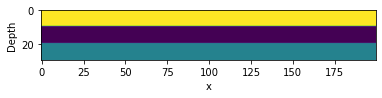

In [3]:
plt.imshow(res_map)
plt.xlabel('x')
plt.ylabel('Depth')

In [4]:
position_x = 98 # position initiale du modèle
noiseEM = 1 
nlay = 40
thickness = 1

thk = pg.Vector(nlay - 1, thickness)  # épaisseur de chaque couche (1m)
centroids = np.cumsum(thk)-thk/2 # centre des couches

# On sample dans le model "res_map" la résistivité correspondant aux position de couches. 
res_EM = np.ones(nlay) *  res_map[0,position_x]
    

Ici pas à 100% compris mais on inverse l'indexing 

-> référence en bas à gauche et en haut à gauche

-> si on prend le 0 du premier modèle il faut le placer dans le 0 de l'autre et inversément
    

In [5]:
for i in centroids:
    if i < 30:
        ab = 29 - np.round((i-0.01)).astype(int) # index dans le modèle resmap
        ab2 = np.floor(i/thickness).astype(int) # index dans le modèle EM
        res_EM[ab2] = res_map[ab,position_x]

Mise en commun des modèles

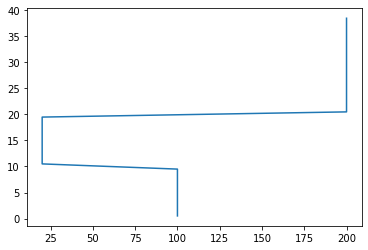

In [6]:
model = pg.cat(thk, res_EM)
noiseEM = 1
plt.plot(np.array(res_EM)[:-1],np.array(centroids));

In [7]:
model.array()

array([  1.,   1.,   1.,   1.,   1.,   1.,   1.,   1.,   1.,   1.,   1.,
         1.,   1.,   1.,   1.,   1.,   1.,   1.,   1.,   1.,   1.,   1.,
         1.,   1.,   1.,   1.,   1.,   1.,   1.,   1.,   1.,   1.,   1.,
         1.,   1.,   1.,   1.,   1.,   1., 100., 100., 100., 100., 100.,
       100., 100., 100., 100., 100.,  20.,  20.,  20.,  20.,  20.,  20.,
        20.,  20.,  20.,  20., 200., 200., 200., 200., 200., 200., 200.,
       200., 200., 200., 200., 200., 200., 200., 200., 200., 200., 200.,
       200., 200.])

Fréquences utilisées

In [8]:
coilspacing = 10
nf = 10
freq = pg.Vector(nf)
freq[0] = 100
freq[1] = 400
freq[2] = 600
freq[3] = 1000
freq[4] = 5000
freq[5] = 8000
freq[6] = 9000
freq[7] = 10000
freq[8] = 20000
freq[9] = 30000

Fonction du modèle

In [9]:
fEM = pg.core.FDEM1dModelling(nlay, freq, coilspacing)

dataEM = fEM(model)

Bruit

In [10]:
for i in range(len(dataEM)):
    dataEM[i] += np.random.random(1)[0] * 0.1

Plot du modèle

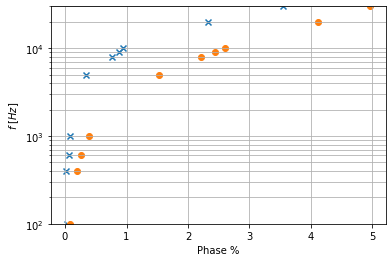

In [11]:
plt.scatter(dataEM[:nf], freq, marker = 'x')
plt.scatter(dataEM[nf:nf*2], freq, marker = 'o')
plt.yscale('log')
plt.ylim((min(freq), max(freq)))
plt.grid(which='both')
plt.xlabel('Phase %')
plt.ylabel('$f$ $[Hz]$');

Il existe une alternative apperemment (plus logique à mon sens)

In [12]:
#Une autre méthode pour comparer. Ca a l'air de donner les memes datas
Data_box_FEM = pg.physics.em.FDEM(x=[1],freqs=freq,coilSpacing=coilspacing)
FOP = pg.core.FDEM1dRhoModelling(centroids, Data_box_FEM.freq(), Data_box_FEM.coilSpacing,-Data_box_FEM.height)
dataEM = FOP(res_EM)


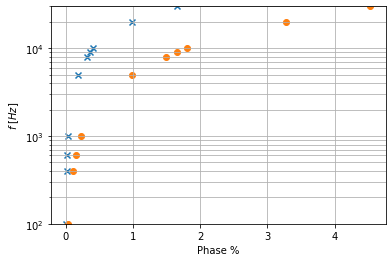

In [13]:
plt.scatter(dataEM[:nf], freq, marker = 'x')
plt.scatter(dataEM[nf:nf*2], freq, marker = 'o')
plt.yscale('log')
plt.ylim((min(freq), max(freq)))
plt.grid(which='both')
plt.xlabel('Phase %')
plt.ylabel('$f$ $[Hz]$');

## Inversion FEM

But : retrouver notre modèle initial à partir des données

In [14]:
transRhoa = pg.trans.TransLog() # paramètre initial - no limit sur les couches
transThk = pg.trans.TransLog()
transRes = pg.trans.TransLogLU(1., 1000.) # limitation des résistivités - entre 1 et 1000 ohmm
transEM = pg.trans.Trans()

nombre de couche au modèle

In [15]:
nLayer_inv = 20 # nombre de layer du modèle inverse

Modèle initial, avant inversion. 2m de couches, uniformes à 10 ohmm

In [16]:
thk_inv = pg.Vector(nLayer_inv - 1, 2)  # 2m d'épaisseur par couches
res_inv = np.ones(nLayer_inv) *  10
initial_model = pg.cat(thk_inv, res_inv)  # mise en commun du modèle

Paramètres principaux -> énorme influence sur le résultat ! Comment trouver les bons ?

In [17]:
fEM_inv = pg.core.FDEM1dModelling(nLayer_inv, freq, coilspacing)
fEM_inv.region(0).setTransModel(transThk)
fEM_inv.region(1).setTransModel(transRes)
lamEM =  100 # paramètre de régulation pour le modèle

Les fameux modèles -> non uniqueness des solutions

In [18]:
invEM = pg.core.Inversion(dataEM, fEM_inv, transEM)
invEM.setModel(initial_model)
invEM.setRelativeError(0.1/100)
invEM.setLambda(lamEM)
invEM.setMarquardtScheme(0.8)
invEM.setDeltaPhiAbortPercent(0.00001)
invEM.setMaxIter(40)
invEM.setBlockyModel(True)

Finalisation du modèle EM

In [19]:
modelEM = invEM.run()
respEM = invEM.response()

Données

In [20]:
np.array(modelEM)

array([  1.53928702,  35.2226779 ,  20.23214385,   1.7030077 ,
         1.38304944,   1.69181879,   2.47510245,   4.1337981 ,
         5.63145163,   5.79442032,   4.94479274,   3.96288597,
         3.27491279,   2.91410358,   2.78608373,   2.78519122,
         2.83060147,   2.87849276,   2.90758611, 960.75205041,
        80.27132796, 255.31810861,   7.3405503 ,   2.02111213,
         6.55704425,  33.85966935,  75.37134913,  94.89388538,
        91.94870427,  75.60177085,  53.57682332,  33.30553404,
        19.19316915,  11.17713926,   7.11492544,   5.12815018,
         4.14624986,   3.66648957,  39.81565309])

Plot

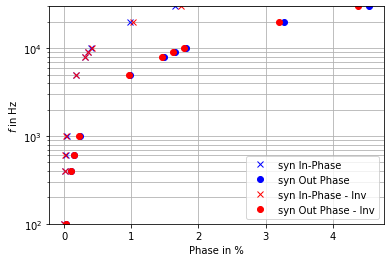

In [21]:
plt.semilogy(dataEM[0:nf], freq, 'bx', label='syn In-Phase')
plt.semilogy(dataEM[nf:nf*2], freq, 'bo', label='syn Out Phase')
plt.semilogy(respEM[0:nf], freq, 'rx', label='syn In-Phase - Inv')
plt.semilogy(respEM[nf:nf*2], freq, 'ro', label='syn Out Phase - Inv')
plt.ylim((min(freq), max(freq)))
plt.xlabel("Phase in %")
plt.ylabel("$f$ in Hz")
plt.grid(which='both')
plt.legend(loc="best");

Reconstruction du modèle initial

In [22]:
model_Final = np.array(modelEM)
cetr = np.cumsum(model_Final[0:nLayer_inv-2])
res_Final = model_Final[nLayer_inv-1:-2]

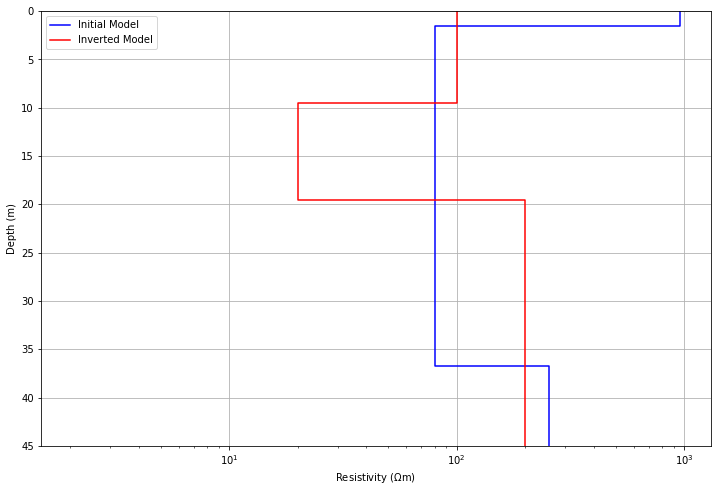

In [23]:
fig, ax = plt.subplots(figsize = ((12,8)))
pg.viewer.mpl.drawModel1D(ax, values=res_Final, depths=cetr,plot='semilogx', 
                          color='blue',label='Initial Model')
pg.viewer.mpl.drawModel1D(ax, values=res_EM[:-1], depths=centroids,plot='semilogx', 
                          color='red',label='Inverted Model')
plt.legend();